In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Usando: SUBID_TotalDomain_WGS84_20140428_2_repaired_geometry.shp, 
ottengo: GEOSException: TopologyException: Input geom 1 is invalid: Self-intersection at 27.629000574570423 61.749901657055602

In [3]:
level = 8
# Load the shapefiles
shapefile_coarser = gpd.read_file(f"../data/shapefiles/hydrobasins/level0{level}/hybas_eu_lev0{level}_v1c.shp")
shapefile_finer = gpd.read_file('../data/shapefiles/FAPAN_domain_fixed_geometry/FAPAN_domain_fixed_geometry_availability05_final.shp')

## Inclusive

In [4]:
# Create a spatial index for finer basins
finer_spatial_index = shapefile_finer.sindex

# Create a dictionary to store finer basins for each coarser basin
finer_basins_per_coarser = {}

progress_bar = tqdm(total=shapefile_coarser.shape[0], position=0, leave=True, smoothing=0)

# Iterate through each coarser basin
for coarser_index, coarser_row in shapefile_coarser.iterrows():
    coarser_basin_id = coarser_row['HYBAS_ID']
    coarser_geometry = coarser_row['geometry']
    
    # Find the finer basins that intersect the coarser basin
    possible_finer_indices = list(finer_spatial_index.intersection(coarser_geometry.bounds))
    finer_basins = set()  # Store the finer basins
    
    # Iterate through each possible finer basin
    for finer_index in possible_finer_indices:
        finer_basin_id = shapefile_finer.at[finer_index, 'SUBID']
        finer_geometry = shapefile_finer.at[finer_index, 'geometry']
        
        # Check if the finer basin intersects the coarser basin
        if coarser_geometry.intersects(finer_geometry):
            # Add the finer basin to the set
            finer_basins.add(finer_basin_id)

    # Store the finer basins for this coarser basin
    finer_basins_per_coarser[coarser_basin_id] = ','.join(str(b) for b in finer_basins)
    
    progress_bar.update(1) 

# Merge the finer basin information into the coarser shapefile
shapefile_coarser['SUBIDs'] = shapefile_coarser['HYBAS_ID'].map(finer_basins_per_coarser)

# Keep only basins with sub-basins and save to a new shapefile
shapefile_coarser = shapefile_coarser[shapefile_coarser["SUBIDs"]!='']
shapefile_coarser = shapefile_coarser.reset_index(drop=True)
shapefile_coarser.to_file(f'../data/shapefiles/FAPAN_level_0{level}_inclusive.shp')

 99%|█████████▉| 25107/25315 [00:56<00:00, 447.05it/s]

100%|██████████| 25315/25315 [01:09<00:00, 361.66it/s]

### At Least 10% of the Coarser Sub-Basin is in Common or 80% of the Area of the Finer Sub-Basin is in the Coarser Sub-Basin

In [3]:
from shapely.geometry import Polygon

progress_bar = tqdm(total=shapefile_coarser.shape[0], position=0, leave=True, smoothing=0)

for index, coarser_row in shapefile_coarser.iterrows():
    coarser_polygon = coarser_row['geometry']
    total_area = coarser_polygon.area

    # Filter finer polygons that intersect with the coarser polygon
    intersecting_finer = shapefile_finer[shapefile_finer.intersects(coarser_polygon)]

    common_areas = []
    subids = []

    for _, finer_row in intersecting_finer.iterrows():
        finer_polygon = finer_row['geometry']
        intersection_area = coarser_polygon.intersection(finer_polygon).area

        if (intersection_area >= 0.1 * total_area) or (intersection_area >= 0.8 * finer_polygon.area):
            subids.append(finer_row['SUBID'])
            common_areas.append(str(intersection_area))


    # Update coarser attribute with SUBIDs
    shapefile_coarser.at[index, 'SUBIDs'] = '_'.join(subids) if len(subids)>0 else ''

    # Update coarser attribute with common areas list
    shapefile_coarser.at[index, 'Common_Areas'] = '_'.join(common_areas) if len(common_areas)>0 else ''

    progress_bar.update(1)

    # Optional: Save the common geometries as a new GeoDataFrame
    #common_geom_gdf = gpd.GeoDataFrame(geometry=common_geometries, crs=shapefile_coarser.crs)
    #common_geom_gdf.to_file(f'common_geometries_{index}.shp')


  0%|          | 0/2240 [00:00<?, ?it/s]/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54318/3981512320.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  shapefile_coarser.at[index, 'SUBIDs'] = '_'.join(subids) if len(subids)>0 else ''
/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54318/3981512320.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  shapefile_coarser.at[index, 'Common_Areas'] = '_'.join(common_areas) if len(common_areas)>0 else ''
100%|██████████| 2240/2240 [03:18<00:00, 11.28it/s]

In [5]:
def plot_coarser_finer(nums, shapefile_finer, shapefile_coarser):
    hybasids = []
    subids = []
    for num in nums:
        polygon_coarser = shapefile_coarser.iloc[[num]]
        hybasids.append(int(polygon_coarser["HYBAS_ID"]))
        #print("coarser: " + str(polygon_coarser["HYBAS_ID"].item()))

        #shapefile_finer.plot(ax = ax, color='black', alpha=0.2)
        #polygon_coarser.plot(ax = ax, edgecolor='blue', linewidth=1)
        if polygon_coarser["SUBIDs"].item() != "":
            #print("finer: "+ polygon_coarser["SUBIDs"].item())

            subids.extend((polygon_coarser["SUBIDs"].item()).split("_"))
    fig, ax = plt.subplots(figsize=(8, 8))
    shapefile_coarser[shapefile_coarser["HYBAS_ID"].isin(hybasids)].plot(ax = ax, edgecolor='blue', linewidth=3)
    shapefile_finer[shapefile_finer["SUBID"].isin(subids)].plot(ax=ax, facecolor="none", edgecolor='red', linewidth=2)
        
    plt.show()

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_58506/1088769564.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  hybasids.append(int(polygon_coarser["HYBAS_ID"]))


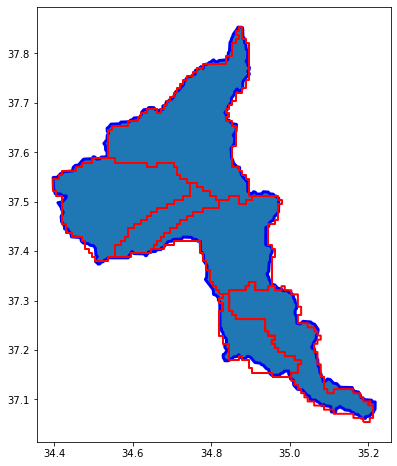

In [19]:
nums = list(range(113, 114))
plot_coarser_finer(nums, shapefile_finer, shapefile_coarser)

In [37]:
shp_coarser_valid = shapefile_coarser[shapefile_coarser["SUBIDs"] != ""]
shp_coarser_valid = shp_coarser_valid.reset_index(drop=True)

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54318/2636949337.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perc_covered_area = common_area/shp_coarser_valid.area


(array([  4.,   2.,   5.,   4.,   5.,  10.,  13.,  39., 127., 868.]),
 array([0.0065389 , 0.10588501, 0.20523112, 0.30457723, 0.40392334,
        0.50326945, 0.60261556, 0.70196167, 0.80130778, 0.90065389,
        1.        ]),
 <BarContainer object of 10 artists>)

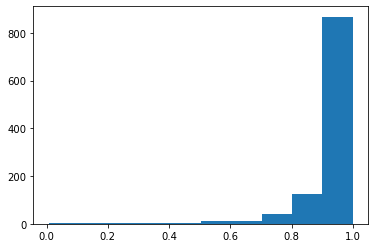

In [5]:
common_areas = [areas.split("_") for areas in shp_coarser_valid["Common_Areas"]]
common_areas = [list(map(float, areas)) for areas in common_areas]
common_area = [sum(areas) for areas in common_areas]
perc_covered_area = common_area/shp_coarser_valid.area
plt.hist(perc_covered_area)

In [6]:
df_finer = pd.read_csv("../data/FAPAN204_05.csv", sep=',')
df_finer.head()

,SUBID,x,y,1,2,3,4,5,6,7,...,195,196,197,198,199,200,201,202,203,204
0,8801544,-22.5854,65.7710,NaN,NaN,NaN,NaN,-1.318167,-0.710667,-1.528167,...,NaN,-1.370000,-0.260333,-0.206061,0.564500,0.652833,0.734500,NaN,NaN,NaN
1,8801548,-24.4720,65.5149,NaN,NaN,NaN,NaN,-0.671554,-0.407242,-0.516090,...,NaN,-0.882667,-0.690604,-2.733667,-0.385919,0.924309,0.417711,NaN,NaN,NaN
2,8000005,9.3096,59.1909,NaN,NaN,0.316444,0.187556,0.371778,-0.197000,-0.361333,...,NaN,-0.461184,1.374222,0.705667,0.906444,0.006111,0.671000,1.385000,NaN,NaN
3,8115258,8.7466,59.1359,NaN,NaN,-0.092833,-0.245083,0.815444,-0.115556,-0.607519,...,NaN,-1.772971,1.125889,0.715222,1.261407,-0.258074,-0.028667,-0.118792,NaN,NaN
4,8115717,9.2398,58.9271,NaN,NaN,1.011778,0.242000,-0.082444,-1.187556,-0.751778,...,NaN,-0.675084,1.587889,1.250889,1.530667,-0.349889,0.421222,1.035111,NaN,NaN


In [7]:
df_coarser = shp_coarser_valid[["HYBAS_ID", "SUBIDs", "Common_Areas"]]
df_coarser = df_coarser.reset_index(drop=True)
df_coarser.head()

,HYBAS_ID,SUBIDs,Common_Areas
0,2060000020,9000344,0.02401311828330892
1,2060000250,9750169,0.047660205477118515
2,2060000350,9749759_9749894_9750078_9749690_9749915,0.0159530869842181_0.02942515868956173_0.02613...
3,2060000360,9000487_9000484_9750185_9755677_9755810_975533...,0.04650632263860207_0.025804922053794144_0.025...
4,2060001220,9001546_9754147_9754198_9754370_9754381_975472...,0.015832480625249445_0.028670940060692374_0.02...


In [8]:
weights_list = []
for i in range(len(common_area)):
    weights = [area_finer/common_area[i] for area_finer in common_areas[i]]
    weights_list.append(weights)

In [9]:
subids_list = [subids.split("_") for subids in shp_coarser_valid["SUBIDs"]]
subids_list = [list(map(int, subids)) for subids in subids_list]

In [10]:
def weighted_average(arr, weights):
    # Remove NaN values and their corresponding weights
    non_nan_mask = ~np.isnan(arr)
    non_nan_arr = arr[non_nan_mask]
    non_nan_weights = weights[non_nan_mask]

    # Check if all values are NaN, in which case return NaN
    if np.all(np.isnan(non_nan_arr)):
        return (np.nan, [0])  # Always return a tuple

    # Compute the weighted average
    weighted_avg = np.sum(non_nan_arr * non_nan_weights) / np.sum(non_nan_weights)

    return weighted_avg, non_nan_weights

In [11]:
months = list(map(str, range(1,205)))
for col in months:
    df_coarser[col] = np.nan

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54318/3892137740.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_coarser[col] = np.nan
/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54318/3892137740.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_coarser[col] = np.nan
/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54318/3892137740.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [12]:
df_perc_avail = pd.DataFrame(index=range(df_coarser.shape[0]), columns=months)

In [13]:
# Initialize the columns in df_coarser
progress_bar = tqdm(total=df_coarser.shape[0], position=0, leave=True, smoothing=0)

for i in range(df_coarser.shape[0]):
    weighted_avg_list = []
    perc_avail_list = []
    for month in range(1, 205):
        arr = df_finer.loc[df_finer["SUBID"].isin(subids_list[i]), str(month)].values
        weights = np.array(weights_list[i])
        weighted_avg, non_nan_weights = weighted_average(arr, weights)
        weighted_avg_list.append(weighted_avg)
        perc_avail_list.append(sum(non_nan_weights))

    df_coarser.iloc[i, 3:] = weighted_avg_list
    df_perc_avail.iloc[i, :] = perc_avail_list

    progress_bar.update(1)

100%|██████████| 2240/2240 [03:26<00:00, 10.83it/s]


100%|██████████| 1077/1077 [09:07<00:00,  1.97it/s]

3406


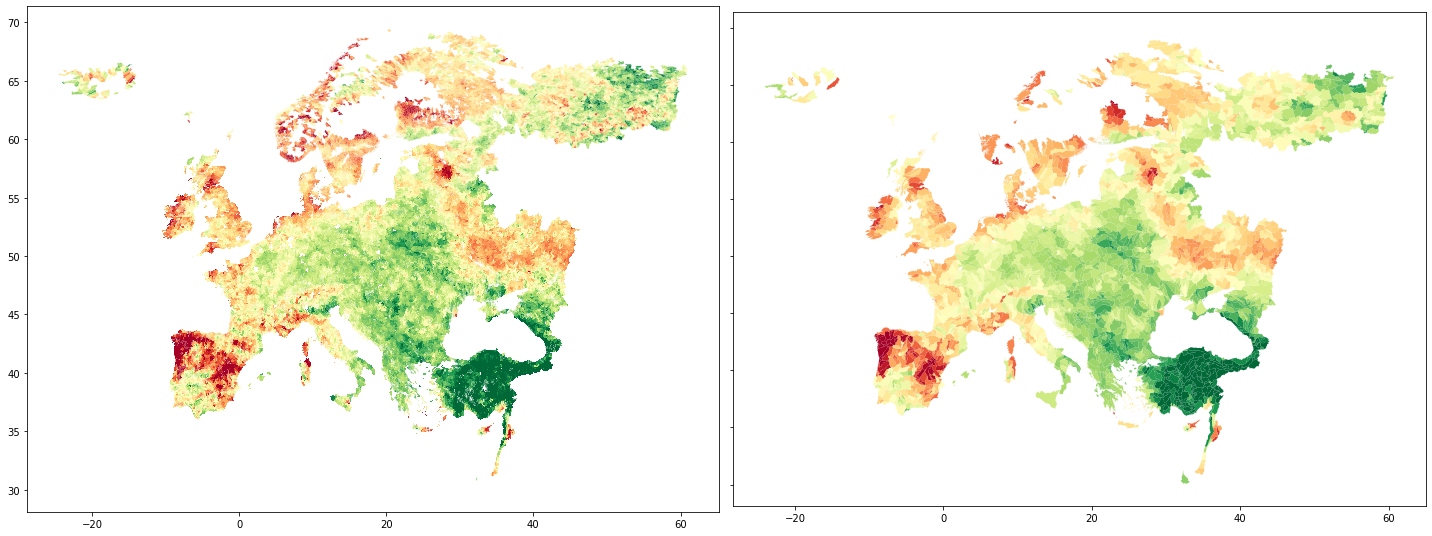

In [ ]:
month = '196'

fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharey=True, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]})  

shapefile_finer.plot(ax=axes[0], column=df_finer[month], cmap='RdYlGn', vmin=-2, vmax=2)
#avail_list = df_perc_avail[month]>=0
#print(len(shp_coarser_valid.loc[avail_list]))
#shp_coarser_valid.loc[avail_list].plot(ax=axes[0], column=df_coarser.loc[avail_list, month], cmap='RdYlGn', vmin=-2, vmax=2)
#axes[0].set_title('Original')

avail_list = df_perc_avail[month]>0.8
print(len(shp_coarser_valid.loc[avail_list]))
shp_coarser_valid.loc[avail_list].plot(ax=axes[1], column=df_coarser.loc[avail_list, month], cmap='RdYlGn', vmin=-2, vmax=2)
#axes[1].set_title('Level 8')

plt.tight_layout()

### I SUBIDs salvati in shp sono troncati i dopo una certa lunghezza! Usa csv

In [14]:
df_coarser.to_csv(f"../data/FAPAN_level_0{level}_corrected.csv", index=False)

In [15]:
df_perc_avail.to_csv(f"../data/perc_covered_0{level}.csv", index=False)

In [16]:
shp_coarser_valid.to_file(f"../data/shapefiles/FAPAN_level_0{level}/FAPAN_level_0{level}_corrected.shp")

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54318/378479435.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_coarser_valid.to_file(f"../data/shapefiles/FAPAN_level_0{level}/FAPAN_level_0{level}_corrected.shp")
